In [1]:
import logging
import numpy as np
import pandas as pd
import h5py as h5
from collections import namedtuple
import matplotlib.pyplot as plt

In [2]:
'''
logging.basicConfig(level=1, format='[%(asctime)s %(levelname)s] %(message)s')
Option = namedtuple("MyStruct", "input train_size")
                    # model name folds batch_size epochs")
                    #structure learning_rate regularizer epochs")
args = Option(
    #input=,
    #train_size = 0.75
    #model='share/reference_number.py',
    #name='NumberNetworkKFOLD',
    #folds=10,
    #batch_size=60,
    #epochs=20,
    #learning_rate=0.0001,
    #regularizer=0.0001,
)
'''

'\nlogging.basicConfig(level=1, format=\'[%(asctime)s %(levelname)s] %(message)s\')\nOption = namedtuple("MyStruct", "input train_size")\n                    # model name folds batch_size epochs")\n                    #structure learning_rate regularizer epochs")\nargs = Option(\n    #input=,\n    #train_size = 0.75\n    #model=\'share/reference_number.py\',\n    #name=\'NumberNetworkKFOLD\',\n    #folds=10,\n    #batch_size=60,\n    #epochs=20,\n    #learning_rate=0.0001,\n    #regularizer=0.0001,\n)\n'

# Load Data

Load from one file

In [196]:
infile = 'jz7w_test.h5'
#infile = 'newjz7wwithoutflip.h5'

logging.info(f'Loading data from data/{infile}')

with h5.File('data/'+infile, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

### Exploring data structure

Plot label distribution

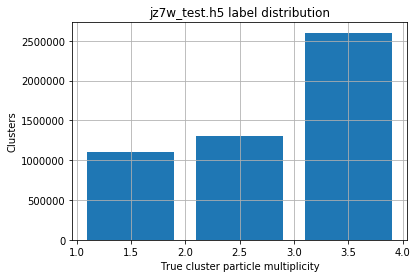

In [197]:
data_y_copy = np.copy(data_y)
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3
data_y_copy = data_y_copy[:,0] + data_y_copy[:,1] + data_y_copy[:,2]
hist = np.histogram(data_y_copy, bins=[0,1.5,2.5,3.5])

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} label distribution')
plt.savefig(f'output/{infile}_label_distribution.png')
plt.show()
plt.close()

Plot label distribution for each layer

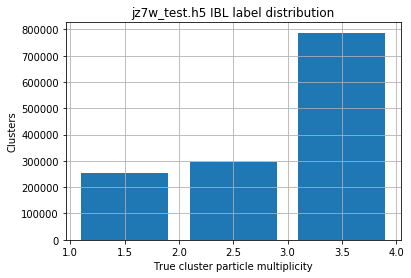

In [198]:
IBLMask = np.logical_and(data_x[:,56]==0, data_x[:,57]==0)
data_y_copy = np.copy(data_y[IBLMask])
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3
data_y_copy = data_y_copy[:,0] + data_y_copy[:,1] + data_y_copy[:,2]
hist = np.histogram(data_y_copy, bins=[0,1.5,2.5,3.5])

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} IBL label distribution')
plt.savefig(f'output/{infile}_IBL_label_distribution.png')
plt.show()
plt.close()

In [199]:
BarrelMask = np.logical_and(data_x[:,56]!=0, data_x[:,57]==0)
data_x[BarrelMask].shape

(3563838, 60)

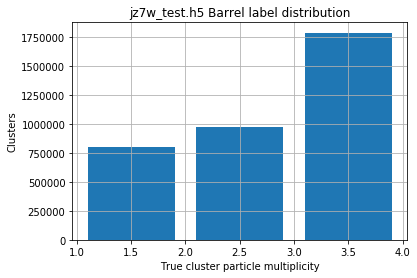

In [200]:
BarrelMask = np.logical_and(data_x[:,56]!=0, data_x[:,57]==0)
data_y_copy = np.copy(data_y[BarrelMask])
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3
data_y_copy = data_y_copy[:,0] + data_y_copy[:,1] + data_y_copy[:,2]
hist = np.histogram(data_y_copy, bins=[0,1.5,2.5,3.5])

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} Barrel label distribution')
plt.savefig(f'output/{infile}_Barrel_label_distribution.png')
plt.show()
plt.close()

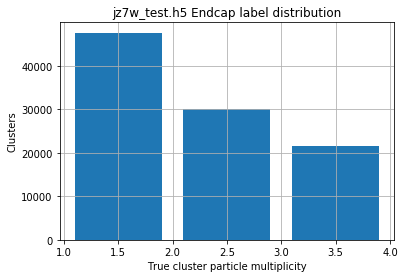

In [201]:
EndcapMask = data_x[:,57]!=0
data_y_copy = np.copy(data_y[EndcapMask])
data_y_copy[:,1] *= 2
data_y_copy[:,2] *= 3
data_y_copy = data_y_copy[:,0] + data_y_copy[:,1] + data_y_copy[:,2]
hist = np.histogram(data_y_copy, bins=[0,1.5,2.5,3.5])

plt.bar(hist[1][1:], hist[0])
plt.ylabel(f"Clusters")
plt.xlabel(f"True cluster particle multiplicity")
plt.grid(True)
plt.title(f'{infile} Endcap label distribution')
plt.savefig(f'output/{infile}_Endcap_label_distribution.png')
plt.show()
plt.close()

Plot layer distribution

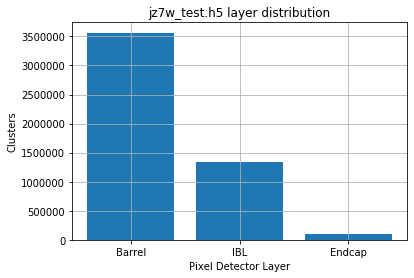

In [202]:
EndcapMask = data_x[:,57]!=0
BarrelMask = np.logical_and(data_x[:,56]!=0, data_x[:,57]==0)
IBLMask = np.logical_and(data_x[:,56]==0, data_x[:,57]==0)
zeros = np.empty((data_x.shape[0], 1))

hist = [zeros[BarrelMask].shape[0], zeros[IBLMask].shape[0], zeros[EndcapMask].shape[0]]
bins = ['Barrel', 'IBL', 'Endcap']

plt.bar(bins, hist)
plt.ylabel(f"Clusters")
plt.xlabel(f"Pixel Detector Layer")
plt.grid(True)
plt.title(f'{infile} layer distribution')
plt.savefig(f'output/{infile}_layer_distribution.png')
plt.show()
plt.close()

### Load, shuffle, and save endcap, barrel, ibl files

In [2]:
layerFiles = ['jz7w_ibl', 'jz7w_barrel', 'jz7w_endcap']
for i, layerFile in enumerate(layerFiles):
    rng = np.random.default_rng(seed=42)
    logging.info('Shuffling {}.h5')
    with h5.File('data/{}.h5'.format(layerFile), 'r') as data:
        data_x = data['input'][()]
        data_y = data['target'][()]

    s = np.arange(data_x.shape[0])
    rng.shuffle(s)
    data_x = data_x[s]
    data_y = data_y[s]

    logging.info('Saving {}_shuffled.h5')
    with h5.File('data/{}_shuffled.h5'.format(layerFile), 'w') as hfile:
        hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
        hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')


Load 4M clusters from each layer for training, save sample for training

In [44]:
layerFiles = ['jz7w_ibl', 'jz7w_barrel', 'jz7w_endcap']

data_x = np.empty((0,data_x.shape[1]))
data_y = np.empty((0,data_y.shape[1]))
for i, layerFile in enumerate(layerFiles):
    logging.info('Loading clusters from {}_shuffled.h5')
    with h5.File('data/{}_shuffled.h5'.format(layerFile), 'r') as data:
        data_x = np.append(data_x, data['input'][:int(4e6)], axis=0)
        data_y = np.append(data_y, data['target'][:int(4e6)], axis=0)

infile = 'jz7w_evensplit_train.h5'

In [52]:
with h5.File('data/{}.h5'.format(infile), 'w') as hfile:
    hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')

# Shuffle Data

In [20]:
logging.info('Shuffling')
rng = np.random.default_rng(seed=42)
s = np.arange(data_x.shape[0])
rng.shuffle(s)

data_x = data_x[s]
data_y = data_y[s]

In [21]:
outfile = 'data/jz7w_evensplit_shuffled.h5'

with h5.File(outfile, 'w') as hfile:
    hfile.create_dataset('input', data=data_x.astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y.astype(np.float32), compression='gzip')

In [22]:
train_split = range(int(12e6))
train_split

range(0, 12000000)

In [23]:
test_split = range(int(12e6), data_x.shape[0])
test_split

range(12000000, 15000000)

# Create Train and Test splits

In [24]:
outtrain = 'jz7w_evensplit_train.h5'
outtest = 'jz7w_evensplit_test.h5'

with h5.File('data/'+outtrain, 'w') as hfile:
    hfile.create_dataset('input', data=data_x[train_split].astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y[train_split].astype(np.float32), compression='gzip')

with h5.File('data/'+outtest, 'w') as hfile:
    hfile.create_dataset('input', data=data_x[test_split].astype(np.float32), compression='gzip')
    hfile.create_dataset('target', data=data_y[test_split].astype(np.float32), compression='gzip')

# Create 10 Splits

In [20]:
for i in range(10):
    with h5.File(f'data/split{i+1}.h5', 'w') as hfile:
        hfile.create_dataset('input', data=data_x[int(data_x.shape[0]/10)*i:int(data_x.shape[0]/10)*(i+1)].astype(np.float32), compression='gzip')
        hfile.create_dataset('target', data=data_y[int(data_x.shape[0]/10)*i:int(data_x.shape[0]/10)*(i+1)].astype(np.float32), compression='gzip')
